# From bean counting to computational extraction of the meaning of things:
## *30 years of NLP history in practice*


### Introduction

#### What I do


- Economic Historian
- Assistant Professor at the Department of Economics
- Aim to understand the biggest economic developments through the lense of history
- AI used to curate historical / archival data

#### Modern econ


- Not rational agents, perfect markets and neoliberalism
- Climate change, economic development, art & culture, institutions, scarce resources, market failures

Two examples of something I do (they are links to slides):
- [A method for coding historical occupations](https://raw.githack.com/christianvedels/OccCANINE/main/Project_dissemination/HISCO%20Slides/Slides.html?panelset=canine&panelset1=example-1#1)
- [A new perspective on how the environment shapes the economy](https://raw.githack.com/christianvedels/A_perfect_storm/main/Slides/slides.html#1)

# 0. Setup



We will be looking at these sentences:

In [2]:
sentences = [
    # Easy
    "I love this movie!",
    "The cake was delicious.",
    "The weather is wonderful today.",
    "I hate this sad music which makes me feel miserable.",

    # Medium
    "I’m not sure if I enjoyed the book, but I liked the ending.",
    "The service was fast, but the food was bland.",
    "I can't believe I’m still waiting for my order after an hour!",

    # Hard
    "What a spectacular event! Everything was so beautifully organized. Too bad the performance was a disaster.",
    "I'm happy with the progress, though it's not as fast as I'd hoped and as such it is still a disappointment.",
    "The customer service was quick, but they didn’t really solve my problem.",
    "It would have been splendid. Absolutely amazing. But it was quite the opposite."
]


### Libraries:

In [25]:
### Libraries

# Run to install AFINN library
# !pip install afinn


from afinn import Afinn
import pandas as pd
import numpy as np

#### Prewritten functions (run before anything else)

These exist to help us not get caught up in logistics later

In [30]:
# Libraries
import requests
import re
import matplotlib.pyplot as plt

def get_notes_from_the_underground():
    """
    This function retrieves *Notes from the Underground* from the Gutenberg
    website. It also does some text cleaning and separates each sentence into
    list elements.
    """
    url = 'https://www.gutenberg.org/cache/epub/600/pg600.txt'
    response = requests.get(url)
    if response.status_code == 200:
        response.encoding = 'utf-8'
        text = response.text

        # Split text into sentences
        sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s|\r\n\r\n', text)

        # Clean text
        sentences = sentences[30:]
        sentences = sentences[:-117]

        return sentences

    else:
        raise Exception(f"Failed to retrieve data from {url}. Status code: {response.status_code}")

    return text

def get_positive_score(x):
    """
    The pipeline returns 'POSITIVE' or 'NEGATIVE' and a probability, where the
    label is based on what is the most likely sentiment of the sentence. It
    turns out to be useful to have one continuous score from -1 to 1, which
    captures completely 'postive' if 1 and completely 'negative' if -1. This
    function handles that.
    """
    if x["label"] == "POSITIVE":
        res_x = x['score']
    elif x["label"] == "NEGATIVE":
        res_x = 1 - x['score']
    else:
        raise Exception(x["label"]+"This should not be possible")

    res_x = res_x*2-1 # Expand to -1 to 1 scale

    return res_x


def print_pretty(x):
    """
    This function prints text in a pretty way.
    """
    for i in x:
        print(f">>{i}<<")
    

### Definition:
> **Sentiment** refers to the emotional tone expressed in a piece of text, indicating whether it is positive, negative, or neutral. It reflects the speaker's or writer's attitude or feelings toward a subject.

*Note: Of course this subjective and depends on context. But in many contexts many subjects agree.*


## 1. Bean counting
![Bag of words](Figures/Bag_of_words.png)



### The idea
*What if we just socres each word, and counted sad and happy words*?

- We could even do this manually with `ctrl + F`
  

### The Afinn library:


- Someone at DTU, Finn Årup Nielsen, decided to 'score' all words in several languages
- See more here: https://github.com/fnielsen/afinn 

In [ ]:
afinn = Afinn()
pd.DataFrame(list(afinn._dict.items()), columns=['Word', 'AFINN_Score']) # Print nice table of AFINN dictionary

,Word,AFINN_Score
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2
...,...,...
3377,yucky,-2
3378,yummy,3
3379,zealot,-2
3380,zealots,-2


#### Doing this automatically

##### One sentence example

In [13]:
from afinn import Afinn
import pandas as pd

# Sentence to analyze
sentence_to_analyze = "I hate this sad music which makes me feel miserable."

# Tokenize the sentence into words and calculate AFINN scores for each word
word_scores = [(word, afinn.score(word)) for word in sentence_to_analyze.split()]

# Create a DataFrame for the words and their scores
word_scores_df = pd.DataFrame(word_scores, columns=['Word', 'AFINN_Score'])

# Calculate the overall AFINN score for the sentence
overall_score_df = pd.DataFrame({
    'Sentence': [sentence_to_analyze],
    'AFINN_Score': [afinn.score(sentence_to_analyze)]
})

# Display the DataFrames
word_scores_df


,Word,AFINN_Score
0,I,0.0
1,hate,-3.0
2,this,0.0
3,sad,-2.0
4,music,0.0
5,which,0.0
6,makes,0.0
7,me,0.0
8,feel,0.0
9,miserable.,-3.0


##### Doing this to all of our sentences:

In [3]:
from afinn import Afinn
import pandas as pd

afinn = Afinn()

# Create a DataFrame to store sentences and their AFINN scores
results_df = pd.DataFrame({
    'Sentence': sentences,
    'AFINN_Score': [afinn.score(sentence) for sentence in sentences]
})

results_df

,Sentence,AFINN_Score
0,I love this movie!,3.0
1,The cake was delicious.,3.0
2,The weather is wonderful today.,4.0
3,I hate this sad music which makes me feel mise...,-8.0
4,"I’m not sure if I enjoyed the book, but I like...",4.0
5,"The service was fast, but the food was bland.",0.0
6,I can't believe I’m still waiting for my order...,0.0
7,What a spectacular event! Everything was so be...,-2.0
8,"I'm happy with the progress, though it's not a...",3.0
9,"The customer service was quick, but they didn’...",-1.0


# 2. Language is more than a bag of words


## 2.1. Problems with the 'bag of words' idea


- Language has grammar
- Context matters

*Still: It is broadly apreciable*

## 2.2. We can do better

1. Take grammar into account using lingstics (~2014): [Valence Aware Dictionary and sEntiment Reasoner](https://github.com/cjhutto/vaderSentiment?tab=readme-ov-file#citation-information)
2. Make use of emergent grammatical understanding in transformer models (~2021 and forward): E.g. `transformers` library and `pipeline("sentiment-analysis")` (See more here: https://huggingface.co/docs/transformers/v4.36.1/en/index)

*We will do the most modern stuff here*

## 2.3. Lets do better

### 2.3.1. Example 1

- We will a particularly hard snippet of text: 
    + `"That would have been splendid. Absoloutly amazing. But it was quite the opposite."`

In [14]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis", model = "distilbert/distilbert-base-uncased-finetuned-sst-2-english")
result = classifier("That would have been splendid. Absoloutly amazing. But it was quite the opposite.")
print(result)

c:\ProgramData\anaconda3\envs\cvs\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cuda:0


[{'label': 'NEGATIVE', 'score': 0.9866785407066345}]


### 2.3.2. Example 2
- We will analyze all the sentences from before

In [20]:
# Perform sentiment analysis on all sentences
sentiment_results = classifier(sentences)

# Create a DataFrame to store the results
sentiment_df = pd.DataFrame({
    'Sentence': sentences,
    'Sentiment_Label': [result['label'] for result in sentiment_results],
    'Sentiment_Score': [result['score'] for result in sentiment_results]
})

# Display the DataFrame
sentiment_df

,Sentence,Sentiment_Label,Sentiment_Score
0,I love this movie!,POSITIVE,0.999878
1,The cake was delicious.,POSITIVE,0.999877
2,The weather is wonderful today.,POSITIVE,0.999888
3,I hate this sad music which makes me feel mise...,NEGATIVE,0.999750
4,"I’m not sure if I enjoyed the book, but I like...",POSITIVE,0.999523
5,"The service was fast, but the food was bland.",NEGATIVE,0.999291
6,I can't believe I’m still waiting for my order...,NEGATIVE,0.991918
7,What a spectacular event! Everything was so be...,NEGATIVE,0.719627
8,"I'm happy with the progress, though it's not a...",NEGATIVE,0.995909
9,"The customer service was quick, but they didn’...",NEGATIVE,0.999708


### 2.3.2. Example 3
- We will *automatically* 'read' all of *Notes from the Underground* by Fyodor Dostoyevsky
- Knowledge of context is required

In [31]:
notes_from_the_underground = get_notes_from_the_underground()
print_pretty(notes_from_the_underground[:20])  # Print the first 20 sentences

>>
I am a sick man....<<
>>I am a spiteful man.<<
>>I am an unattractive man.<<
>>I
believe my liver is diseased.<<
>>However, I know nothing at all about my
disease, and do not know for certain what ails me.<<
>>I don’t consult a
doctor for it, and never have, though I have a respect for medicine and
doctors.<<
>>Besides, I am extremely superstitious, sufficiently so to
respect medicine, anyway (I am well-educated enough not to be
superstitious, but I am superstitious).<<
>>No, I refuse to consult a
doctor from spite.<<
>>That you probably will not understand.<<
>>Well, I
understand it, though.<<
>>Of course, I can’t explain who it is precisely
that I am mortifying in this case by my spite: I am perfectly well
aware that I cannot “pay out” the doctors by not consulting them; I
know better than anyone that by all this I am only injuring myself and
no one else.<<
>>But still, if I don’t consult a doctor it is from spite.<<
>>
My liver is bad, well—let it get worse!<<
>>I have been going

In [36]:
# Perform sentiment analysis on the text from *Notes from the Underground*
out = classifier(notes_from_the_underground)
result = [get_positive_score(x) for x in out]  # Turn into -1 to 1 scale

# Create a DataFrame with the results
result_df = pd.DataFrame({
	'sentiment': result,
	'sentence': notes_from_the_underground
})
result_df

,sentiment,sentence
0,-0.998312,\r\nI am a sick man....
1,-0.980231,I am a spiteful man.
2,-0.991101,I am an unattractive man.
3,-0.997110,I\r\nbelieve my liver is diseased.
4,-0.998645,"However, I know nothing at all about my\r\ndis..."
...,...,...
2379,0.982832,We are developing a taste for it.
2380,-0.832976,Soon we shall contrive to be\r\nborn somehow f...
2381,-0.994718,But enough; I don’t want to write more from\r\...
2382,-0.774726,[The notes of this paradoxalist do not end her...


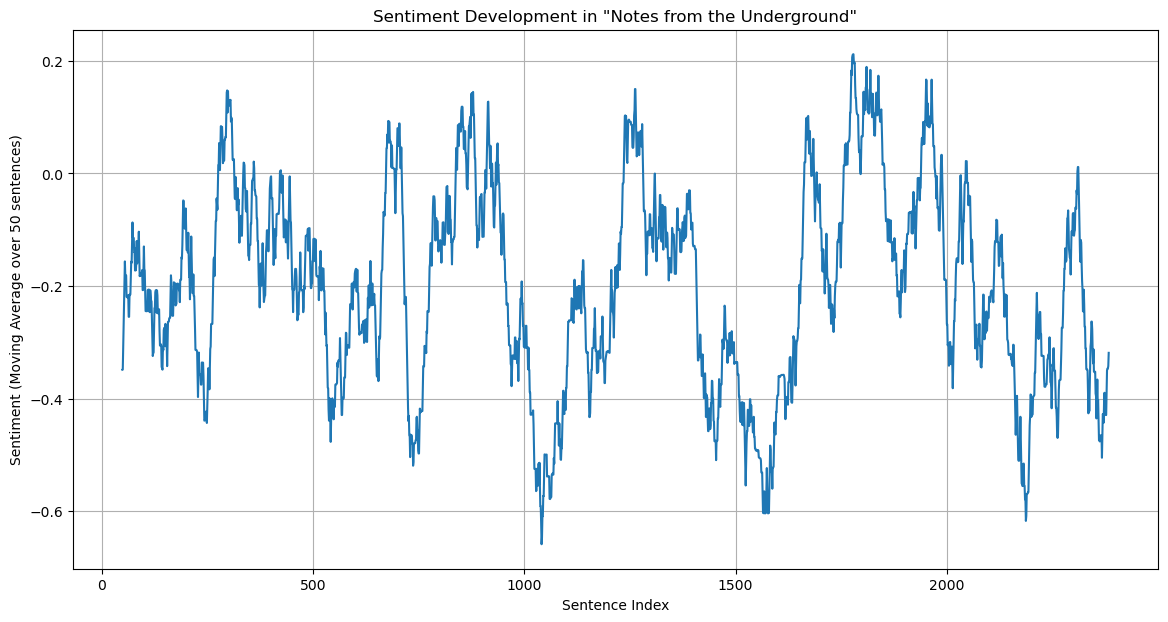

In [38]:
# Compute the moving average with a window of 50 sentences
window = 50
mov_avg = np.convolve(scores, np.ones(window)/window, mode='valid')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(np.arange(window-1, window-1 + len(mov_avg)), mov_avg)
plt.xlabel('Sentence Index')
plt.ylabel('Sentiment (Moving Average over 50 sentences)')
plt.title('Sentiment Development in "Notes from the Underground"')
plt.grid(True)
plt.show()

# 3. Final thoughts

### 3.1. Drawbacks


- These methods are slightly worse than humans for msot things
- Sometimes better

### 3.2. Utility



- These methods are fully replicable - no judgement calls are hiddden
- They are vastly faster and cheaper than research assistants

### 3.3. Two ways this could go


- We care less about quality
- We care more about quality

### 3.4. More examples


- [From last years summer school](https://raw.githack.com/sdu-econhist/hedg-summer-school-ai/refs/heads/main/slides_cv_version.slides.html#/6)